# Lesson 2 : LangGraph Components

In [18]:
from dotenv import load_dotenv
_ = load_dotenv(override=True)

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [5]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

In [86]:
def __call_openai(self, state: AgentState):

        messages = state['messages']

        if self.system:
            messages = [SystemMessage(content=self.system)] + messages

        message = self.llm.invoke(messages)

        return {'messages': [message]}

In [88]:
graph = StateGraph(AgentState)
graph.add_node("openai", __call_openai)
#graph.add_node("end", END)
graph.add_edge("openai", END)
graph.set_entry_point("openai")
graph = graph.compile()

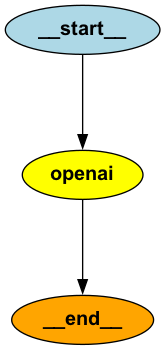

In [89]:
Image(graph.get_graph().draw_png())

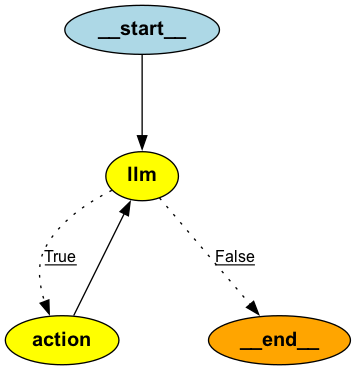

In [22]:
from IPython.display import Image
# Add dot and graphviz to Path

Image(abot.graph.get_graph().draw_png())

In [23]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_08k3eN7RrVoAIm8o70eEgigg', 'type': 'tool_call'}
Back to the model!


In [25]:
result['messages'][-1].content

'The current weather in San Francisco is as follows:\n- Temperature: 11.7°C (53.1°F)\n- Condition: Clear\n- Wind: 3.6 kph from the SW\n- Humidity: 46%\n- Visibility: 16.0 km\n- Pressure: 1022.0 mb\n\nIs there anything else you would like to know about the weather or any other information related to San Francisco?'

In [30]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_ngZZtn7AesRyP7XtXskNXXBP', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_EbKEkjFz3Jj4GHimbYQUGSLx', 'type': 'tool_call'}
Back to the model!


In [32]:
result['messages'][-1].content

'The current weather in San Francisco is 56.1°F with clear skies. The wind speed is 3.6 kph from the south. The humidity is at 81%.\n\nIn Los Angeles, the current temperature is 58.4°F with clear skies. The wind speed is 4.3 kph from the northeast. The humidity is at 14%.'

In [36]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 Super Bowl winner'}, 'id': 'call_kC6guYLkX560BkW8mhFN3YND', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_30WzW0QZFMki4AAKPGzZyL5r', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2024'}, 'id': 'call_6nHI0VicnN5Yqj1TioJH1jiP', 'type': 'tool_call'}
Back to the model!


In [38]:
print(result['messages'][-1].content)

1. **Who won the Super Bowl in 2024?**  
   The Kansas City Chiefs won the Super Bowl in 2024.

2. **In what state is the winning team headquarters located?**  
   The Kansas City Chiefs' headquarters is located in Kansas City, Missouri.

3. **What is the GDP of that state?**  
   The exact 2024 GDP figure for Missouri wasn't directly found, but historical and other economic data can be accessed through resources like the U.S. Bureau of Labor Statistics and the Federal Reserve Economic Data (FRED). If you need the exact figure, I recommend checking the latest reports on Missouri's economy from these sources.


In [74]:
import pandas as pd
ds = pd.read_csv("names_tobe_translated.csv", dtype='str')
ds.columns =['original_name']

In [75]:
aa = ds['original_name'].tolist()

In [76]:
aa[:10]

[' Duo van Burgers',
 ' Kroket met friet',
 ' Oourgettesoep ',
 ' Veganistische salade',
 '1 Boterham met een ei',
 '1 boterham met jam',
 '1 kroket met brood',
 '1 Kroket met brood',
 '1 x Tapas kind onbeperkt',
 '1 x Tapas klein']

In [50]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

In [52]:
prompt = ChatPromptTemplate.from_template(
    "Translate the dutch text to plain english of given text {text}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

In [53]:
chain = prompt | model | output_parser

In [55]:
a = chain.invoke({"text": " Duo van Burgers'"})

In [78]:
model = ChatOpenAI()
def get_eng_text(input: str):
    messages = [
                (
                    "system",
                    "You are a helpful translator. Translate the user sentence to plain english word if possible. Give me in a word. If yo dont know the information or need more information. Give me the answer as 'UNKNOWN',
                ),
                ("human", input),
            ]
    ss = model.invoke(messages)
    return ss.content

In [60]:
ss = model.invoke(messages)

In [79]:
for a in aa[:10]:
    out = get_eng_text(a)
    print(out)
    

Two burgers
Croquette with fries.
Zucchinisoup
Vegan salad
1 slice of bread with an egg
1 slice of bread with jam
1 croquette with bread
1 croquette with bread
1 x Unlimited tapas.
1 small tapas


In [80]:
ds['translated_name'] = ds['original_name'].apply(lambda x: get_eng_text(x))

In [84]:
ds.to_parquet("translated_names.parquet")

In [83]:
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 37.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
